In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from IPython import display 

In [3]:
from code_AVO import SimpleModel, make_optimizer_step, get_gradient_penalty

In [4]:
from skimage import transform
from mnist import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

all_data = np.vstack((X_train, X_val, X_test))
all_data = all_data.reshape(-1, 28, 28)

subsample_indices = np.random.choice(len(all_data), 2000, replace=False)

all_data = all_data[subsample_indices]

results_dict = dict()

In [5]:
def get_base_data(half_n_samples, alpha0=0):
    X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
    all_data = np.vstack((X_train, X_val, X_test))
    all_data = all_data.reshape(-1, 28, 28)
    subsample_indices = np.random.choice(len(all_data), half_n_samples, replace=False)

    all_data = all_data[subsample_indices]
    
    if alpha0 != 0:
        all_data = rotate_dataset(all_data, alpha0)
    return all_data


In [18]:
a = get_base_data(10, 0)

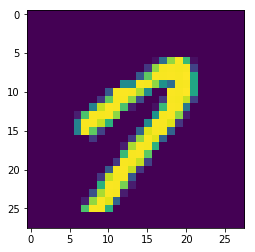

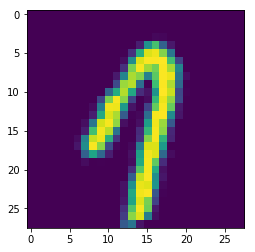

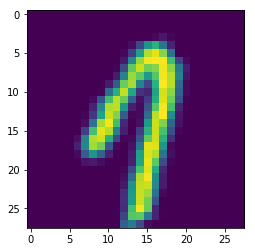

In [19]:
plt.imshow(a[0])
plt.figure()
plt.imshow(transform.rotate(a[0], 25 ))
b = transform.rotate(a[0], 10 )
plt.figure()
plt.imshow(transform.rotate(b, 15 ))

In [8]:
def rotate_dataset(dataset, angles):
    return np.array(list(map(lambda i: transform.rotate(dataset[i], angles[i]), np.arange(dataset.shape[0]))))

In [9]:
batch_size = 50
learning_rate = 0.01
lambda_gradient = 0.01 # Gradient penalty
lambda_entropy = 1 #5. # Entropy penalty
beta1 = 0.5
beta2 = 0.9
critic_steps = 100
count_steps = 300

batch_shape = (batch_size, 1)
critic_shape = (batch_size, 1)


In [10]:
proposal_initial_mu = 45.
proposal_initial_lg_sigma = np.log(10.)
mu = torch.tensor(proposal_initial_mu, requires_grad=True)
lg_sigma = torch.tensor(proposal_initial_lg_sigma, requires_grad=True)
entropy_proposal_op = lg_sigma

In [11]:
def get_data_op():
    indices = np.random.choice(np.arange(all_data.shape[0]), size=batch_size)
    return all_data[indices]

In [12]:
all_data.shape

(2000, 28, 28)

In [13]:
class ModelMNIST(nn.Module):
    def __init__(self, n_features=1):
        super(ModelMNIST, self).__init__()
        self.lin1 = nn.Linear(n_features, 128)
        self.lin2 = nn.Linear(128, 128)
        self.lin3 = nn.Linear(128, 1)
        self.dropout1 = nn.Dropout()
        self.dropout2 = nn.Dropout()

    def forward(self, x):
       x = self.dropout2(F.relu(self.lin2(self.dropout1(F.relu(self.lin1(x))))))
       return self.lin3(x)

critic = ModelMNIST(all_data[0].reshape(-1).shape[0])

In [14]:
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=learning_rate, betas=(beta1, beta2))
proposal_optimizer = torch.optim.Adam([mu, lg_sigma], lr=0.2, betas=(beta1, beta2))

In [15]:
critic_losses = np.zeros(count_steps)
proposal_losses = np.zeros(count_steps)
hist_mu = np.zeros(count_steps)
hist_lg_sigma = np.zeros(count_steps)

Step 290: mu = 2.473189353942871, sigma = 6.970629692077637, critic_loss = 399.3961486816406


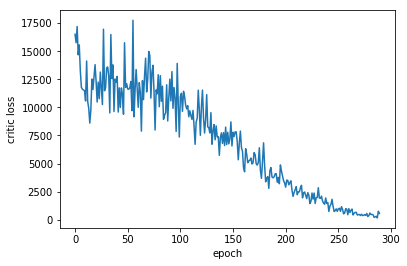

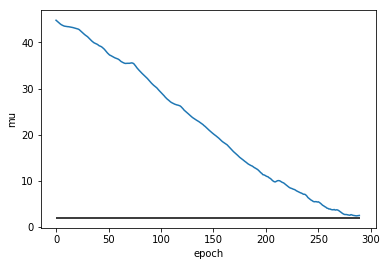

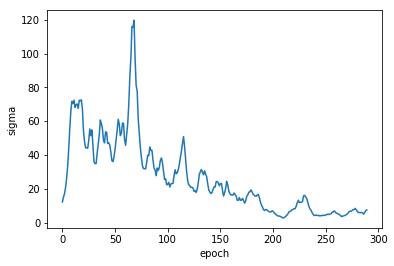

In [16]:
print('Step 0: mu = {}, sigma = {}'.format(mu, torch.exp(lg_sigma)))
_tgp = np.zeros(count_steps)
for epoch in range(0, count_steps):
    _c_l = np.zeros(critic_steps)
    
    for idx in range(0, critic_steps):
        data_op = get_data_op()

        proposal_distribution = torch.distributions.Normal(loc=mu, 
                                                           scale=torch.exp(lg_sigma))
        sample_proposal_op = proposal_distribution.sample(torch.Size(batch_shape))
        lg_proposal_op = proposal_distribution.log_prob(sample_proposal_op)
        
        simulate_op = rotate_dataset(data_op, sample_proposal_op)
        
        data_op = torch.tensor(data_op.reshape(data_op.shape[0], -1), dtype=torch.float)
        simulate_op = torch.tensor(simulate_op.reshape(simulate_op.shape[0], -1), dtype=torch.float)

        critic_data = critic(data_op)
        critic_fake = critic(simulate_op)

        gradient_penalty = get_gradient_penalty(data_op, simulate_op, critic)
        critic_loss = torch.mean(critic_fake - critic_data + lambda_gradient * gradient_penalty)

        make_optimizer_step(critic_loss, critic_optimizer)
    
    _tgp[epoch] = gradient_penalty
    critic_loss = torch.mean(critic_fake - critic_data + gradient_penalty)
    critic_losses[epoch] = critic_loss
    
    sample_proposal_op = proposal_distribution.sample(torch.Size(batch_shape))
    lg_proposal_op = proposal_distribution.log_prob(sample_proposal_op)


    data_op = get_data_op()
    simulate_op = rotate_dataset(data_op, sample_proposal_op)
    simulate_op = torch.tensor(simulate_op.reshape(simulate_op.shape[0], -1), dtype=torch.float)

    critic_fake = critic(simulate_op)

    loss_proposal = torch.mean(-critic_fake * lg_proposal_op + lambda_entropy * proposal_distribution.entropy())
    proposal_losses[epoch] = loss_proposal

    make_optimizer_step(loss_proposal, proposal_optimizer, retain_graph=True)
    
    hist_mu[epoch] = mu
    hist_lg_sigma[epoch] = lg_sigma
    if epoch%10 == 0:
        display.clear_output()
        print('Step {}: mu = {}, sigma = {}, critic_loss = {}'.format(epoch, mu, torch.exp(lg_sigma), critic_loss))
        
        plt.plot(critic_losses[:epoch])
        plt.xlabel('epoch')
        plt.ylabel('critic loss')

        plt.figure()
        plt.hlines(np.log(7.), 0, epoch)
        plt.plot(hist_mu[:epoch])
        plt.xlabel('epoch')
        plt.ylabel('mu')

        plt.figure()
        plt.plot(np.exp(hist_lg_sigma[:epoch]))
        plt.xlabel('epoch')
        plt.ylabel('sigma')

        plt.show()

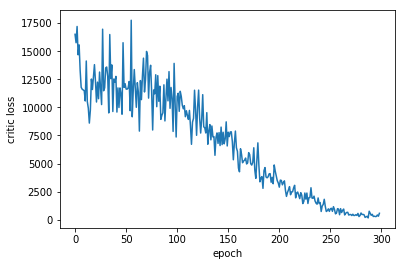

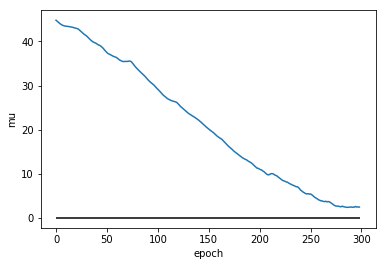

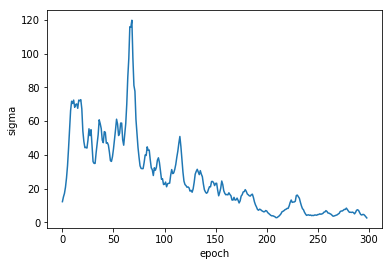

In [17]:
plt.plot(critic_losses[:epoch])
plt.xlabel('epoch')
plt.ylabel('critic loss')

plt.figure()
plt.hlines(0, 0, epoch)
plt.plot(hist_mu[:epoch])
plt.xlabel('epoch')
plt.ylabel('mu')

plt.figure()
plt.plot(np.exp(hist_lg_sigma[:epoch]))
plt.xlabel('epoch')
plt.ylabel('sigma')

plt.show()

The AVO converged to the correct values. Success!